# Another try to segment images using HED (holistic edge detection)

In [1]:
### script adopted from:
#https://www.pyimagesearch.com/2019/03/04/holistically-nested-edge-detection-with-opencv-and-deep-learning/

In [2]:
# load libraries
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

In [4]:
image = cv2.imread("./train/Kartoffel/TileScan3_Region 6_s18_RAW_ch00.tif",cv2.IMREAD_COLOR)
edge_detector = "./"

In [6]:
class CropLayer(object):
	def __init__(self, params, blobs):
		# initialize our starting and ending (x, y)-coordinates of
		# the crop
		self.startX = 0
		self.startY = 0
		self.endX = 0
		self.endY = 0

	def getMemoryShapes(self, inputs):
		# the crop layer will receive two inputs -- we need to crop
		# the first input blob to match the shape of the second one,
		# keeping the batch size and number of channels
		(inputShape, targetShape) = (inputs[0], inputs[1])
		(batchSize, numChannels) = (inputShape[0], inputShape[1])
		(H, W) = (targetShape[2], targetShape[3])

		# compute the starting and ending crop coordinates
		self.startX = int((inputShape[3] - targetShape[3]) / 2)
		self.startY = int((inputShape[2] - targetShape[2]) / 2)
		self.endX = self.startX + W
		self.endY = self.startY + H

		# return the shape of the volume (we'll perform the actual
		# crop during the forward pass
		return [[batchSize, numChannels, H, W]]

	def forward(self, inputs):
		# use the derived (x, y)-coordinates to perform the crop
		return [inputs[0][:, :, self.startY:self.endY,
				self.startX:self.endX]]

# load our serialized edge detector from disk
protoPath = "./deploy.prototxt"
modelPath = "./hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# register our new layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

# load the input image and grab its dimensions
(H, W) = image.shape[:2]

# convert the image to grayscale, blur it, and perform Canny
# edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
canny = cv2.Canny(blurred, 30, 150)

# construct a blob out of the input image for the Holistically-Nested
# Edge Detector
blob = cv2.dnn.blobFromImage(image, scalefactor=2.5, size=(W, H),
	mean=(np.array(image).mean(axis=(0,1))
),
	swapRB=False, crop=False)

# set the blob as the input to the network and perform a forward pass
# to compute the edges
net.setInput(blob)
hed = net.forward()
hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")

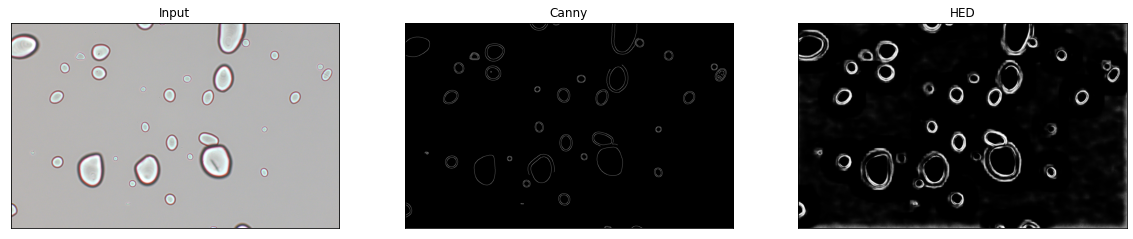

In [7]:
plt.figure(figsize = (20,14))
plt.subplot(131),plt.imshow(image,cmap = 'gray'),plt.title('Input')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(canny,cmap = 'gray'),plt.title('Canny')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(hed,cmap = 'gray'),plt.title('HED')
plt.xticks([]), plt.yticks([])
plt.show()

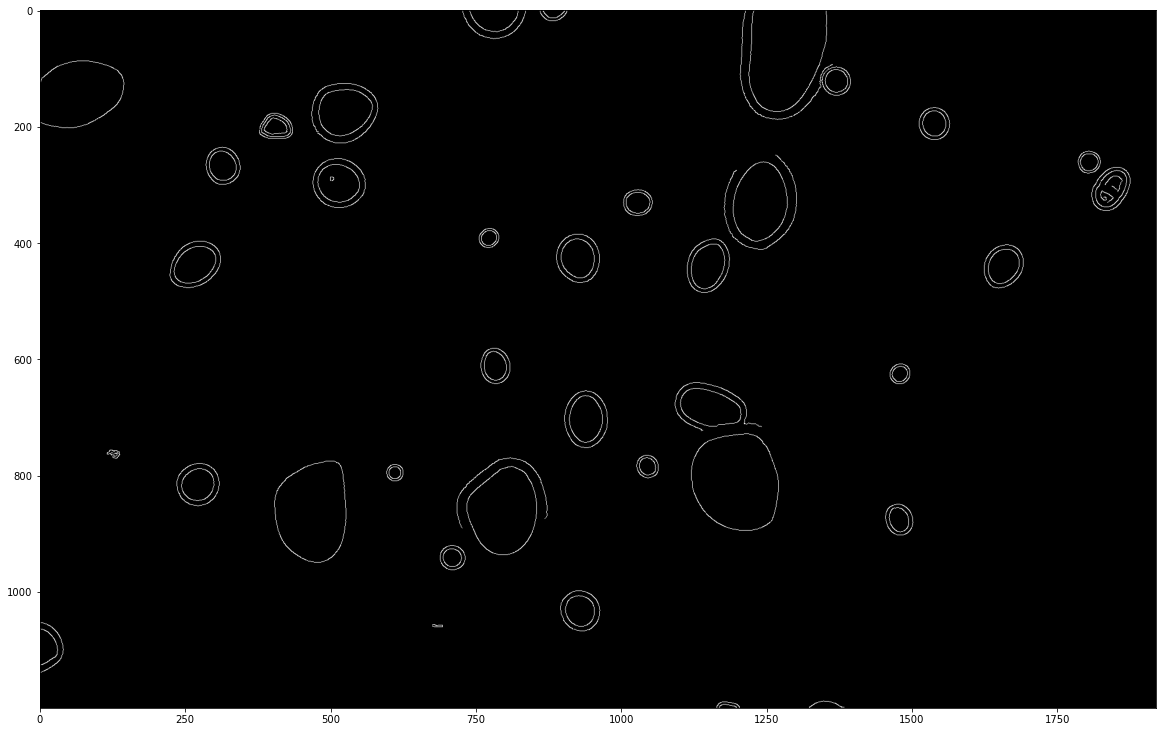

In [8]:
plt.figure(figsize = (20,14))
plt.imshow(canny,cmap = 'gray')

In [9]:
kernel2 = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(canny,cv2.MORPH_CLOSE,kernel2, iterations = 5)

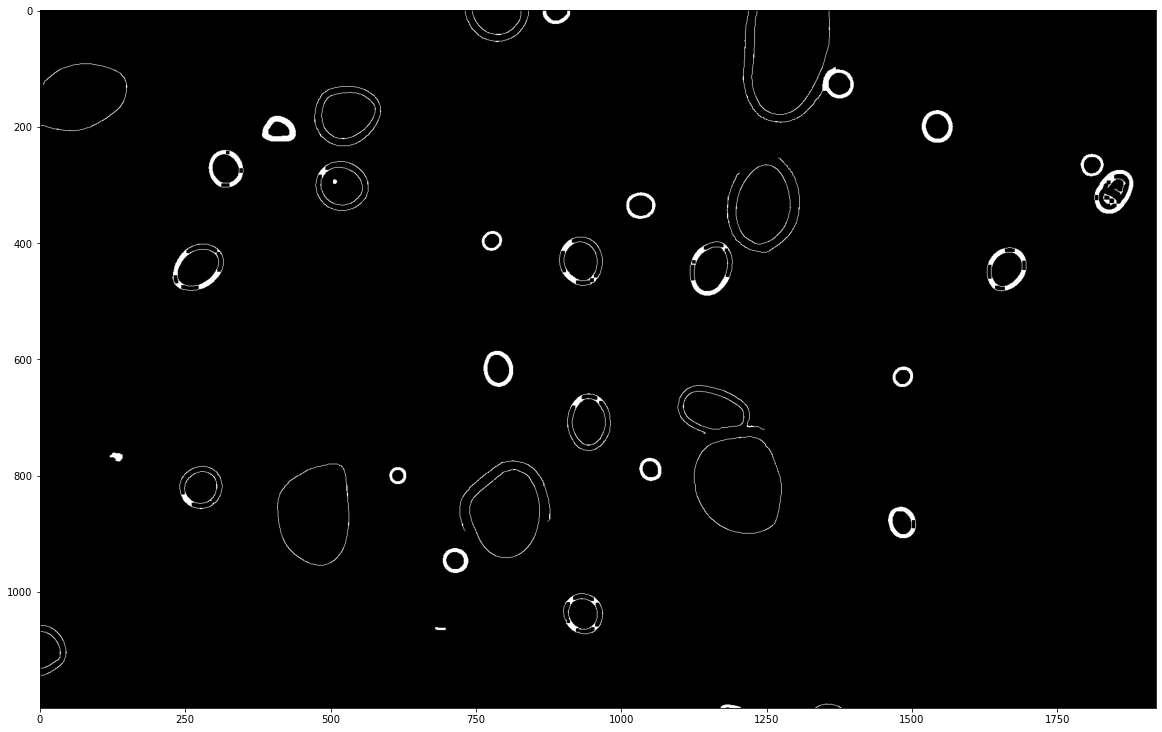

In [10]:
plt.figure(figsize = (20,14))
plt.imshow(opening,cmap = 'gray')

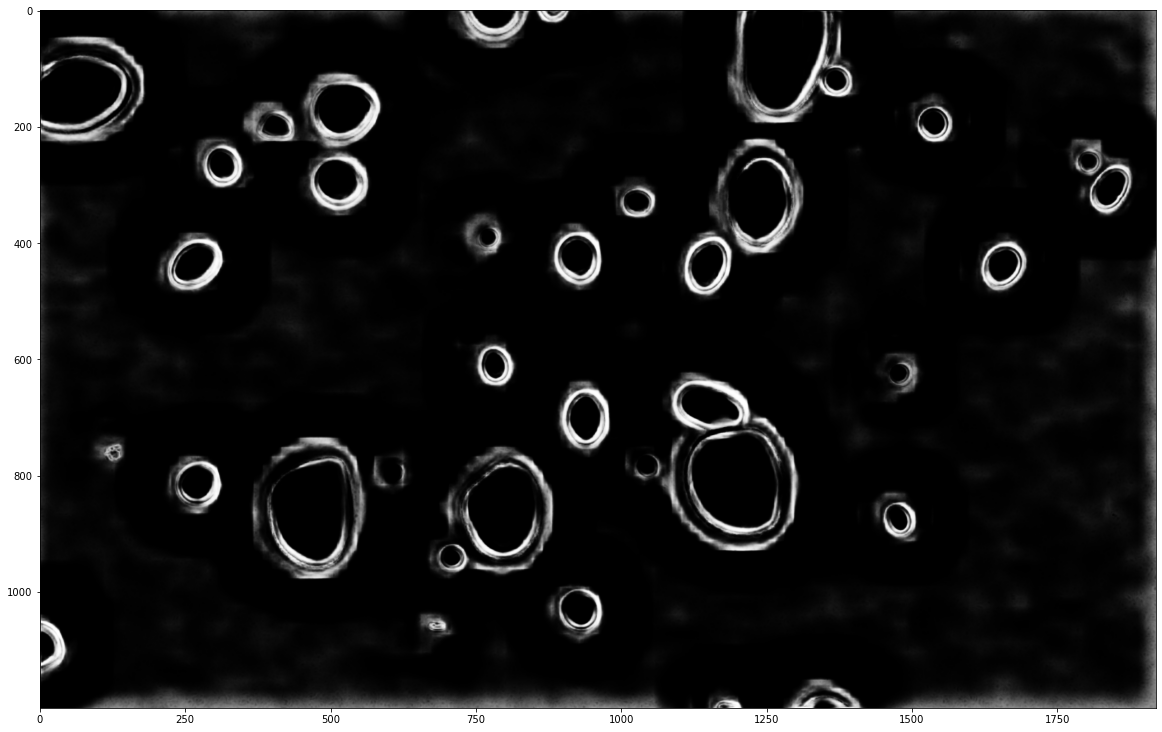

In [11]:
plt.figure(figsize = (20,14))
plt.imshow(hed,cmap = 'gray')